# Multiclass Prediction Cirrhosis Outcomes - Third Attempt

### EDA Checklist

* What question(s) are you trying to solve (or prove wrong)?
    - What is our target and what do we want to accomplish 
* What kind of data do you have and how do you treat different types?
    - Numerical - Categorical (what is the best way to encode for this data ?)
* What’s missing from the data and how do you deal with it?
    - Imputing
* Where are the outliers and why should you care about them?
    - Visualization, distribution
* How can you add, change or remove features to get more out of your data?
    - Feature engineering

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import log_loss
from sklearn.ensemble import VotingClassifier
import optuna

# model imports
#xgboost
from xgboost import XGBClassifier

# lightGBM
from lightgbm import LGBMClassifier

# catboost
from catboost import CatBoostClassifier

print('imports finished')
print('imports done')

imports finished
imports done


## Load Data

In [2]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
print('data loaded')

data loaded


In [3]:
# split the data
train_dataset, val_dataset = train_test_split(train_data, test_size=0.3, random_state=42)
print('data splitted')

data splitted


In [4]:
# extract the labels
train_labels = train_dataset.pop('Status')
val_labels = val_dataset.pop('Status')
print('labels extracted')

print(train_labels.shape)
print(val_labels.shape)

labels extracted
(5533,)
(2372,)


In [5]:
# because the labels are in categorical values, we need to encode them
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.fit_transform(val_labels)

print('train labels encoded', f"{train_labels_encoded}")
print('val labels encoded', f"{val_labels_encoded}")

train labels encoded [2 0 2 ... 0 0 0]
val labels encoded [0 0 0 ... 0 2 0]


## EDA

### Basic Statistics

In [6]:
# general info
print(train_dataset.shape)
print(val_dataset.shape)
print(train_dataset.info)

(5533, 19)
(2372, 19)
<bound method DataFrame.info of         id  N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders  \
3755  3755    3839          Placebo  18352   M       N            N       N   
4010  4010    3445          Placebo  23445   F       N            Y       Y   
2656  2656    1447          Placebo  25873   F       Y            Y       N   
4320  4320      71          Placebo  20567   F       Y            Y       Y   
1611  1611    1827          Placebo  18964   M       Y            Y       Y   
...    ...     ...              ...    ...  ..     ...          ...     ...   
5226  5226     515          Placebo  16858   F       N            N       N   
5390  5390     694  D-penicillamine  17090   F       N            Y       Y   
860    860     769          Placebo  16718   F       N            Y       N   
7603  7603    2527  D-penicillamine  17664   F       N            N       N   
7270  7270    4050  D-penicillamine  16279   F       N            Y       N  

In [7]:
train_dataset.head(15)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
3755,3755,3839,Placebo,18352,M,N,N,N,N,1.2,346.0,3.48,67.0,2184.0,128.65,100.0,269.0,9.9,3.0
4010,4010,3445,Placebo,23445,F,N,Y,Y,N,0.6,286.0,3.94,96.0,856.0,71.30,90.0,410.0,11.5,4.0
2656,2656,1447,Placebo,25873,F,Y,Y,N,N,1.4,151.0,3.40,50.0,559.0,73.53,49.0,234.0,13.0,4.0
4320,4320,71,Placebo,20567,F,Y,Y,Y,N,3.4,260.0,3.01,77.0,728.0,137.95,68.0,190.0,12.0,4.0
1611,1611,1827,Placebo,18964,M,Y,Y,Y,N,1.0,360.0,3.99,380.0,967.0,89.90,154.0,278.0,10.0,3.0
4471,4471,1765,Placebo,14899,F,N,Y,N,N,1.4,299.0,3.36,227.0,1083.0,137.95,67.0,200.0,9.8,3.0
7442,7442,2609,Placebo,19270,F,N,N,N,N,0.6,263.0,3.85,52.0,720.0,134.85,85.0,192.0,9.9,2.0
3145,3145,2332,D-penicillamine,20604,F,N,N,N,N,0.7,223.0,3.66,39.0,676.0,66.65,104.0,394.0,9.9,2.0
7617,7617,1300,Placebo,19258,F,N,N,N,N,0.7,364.0,3.41,52.0,911.0,96.00,33.0,296.0,10.0,3.0
4690,4690,515,Placebo,12544,F,N,Y,N,N,6.6,576.0,3.80,140.0,1975.0,182.90,171.0,248.0,11.0,4.0


In [8]:
train_dataset.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,5533.000000,5533.000000,5533.000000,5533.000000,5533.000000,5533.00000,5533.000000,5533.000000,5533.000000,5533.000000,5533.000000,5533.000000,5533.000000
mean,3980.505874,2031.740286,18326.591542,2.526676,352.044280,3.54861,82.774806,1823.073992,114.197219,115.490692,265.627327,10.623134,3.031448
std,2271.889482,1085.502845,3690.814730,3.647229,198.003275,0.34542,74.163166,1894.478243,48.298560,51.557918,87.268159,0.781066,0.866811
min,1.000000,41.000000,9598.000000,0.300000,120.000000,1.96000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,2035.000000,1235.000000,15526.000000,0.700000,248.000000,3.35000,39.000000,834.000000,75.950000,85.000000,211.000000,10.000000,2.000000
50%,3972.000000,1832.000000,18499.000000,1.100000,299.000000,3.58000,63.000000,1174.000000,106.950000,104.000000,265.000000,10.600000,3.000000
75%,5964.000000,2689.000000,20684.000000,2.900000,390.000000,3.77000,101.000000,1860.000000,137.950000,139.000000,317.000000,11.000000,4.000000
max,7902.000000,4795.000000,28650.000000,28.000000,1775.000000,4.64000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000


In [9]:
# Basic statistics for categorical values
ds_cat_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona', 'num_miss', 'pct_miss'])
tmp = pd.DataFrame()
for c in train_dataset.columns:
    tmp['column'] = [c]
    tmp['values'] = [train_dataset[c].unique()]
    tmp['values_count_incna'] = len(list(train_dataset[c].unique()))
    tmp['values_count_nona'] = int(train_dataset[c].nunique())
    tmp['num_miss'] = train_dataset[c].isnull().sum()
    tmp['pct_miss'] = (train_dataset[c].isnull().sum()/ len(train_dataset)).round(3)*100
    ds_cat_stats = pd.concat([ds_cat_stats, tmp], ignore_index=True)
ds_cat_stats

/var/folders/dr/hm1zdkfj49gchtvw9s1q_r5r0000gn/T/ipykernel_7077/349899314.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ds_cat_stats = pd.concat([ds_cat_stats, tmp], ignore_index=True)


,column,values,values_count_incna,values_count_nona,num_miss,pct_miss
0,id,"[3755, 4010, 2656, 4320, 1611, 4471, 7442, 314...",5533,5533,0,0.0
1,N_Days,"[3839, 3445, 1447, 71, 1827, 1765, 2609, 2332,...",427,427,0,0.0
2,Drug,"[Placebo, D-penicillamine]",2,2,0,0.0
3,Age,"[18352, 23445, 25873, 20567, 18964, 14899, 192...",376,376,0,0.0
4,Sex,"[M, F]",2,2,0,0.0
5,Ascites,"[N, Y]",2,2,0,0.0
6,Hepatomegaly,"[N, Y]",2,2,0,0.0
7,Spiders,"[N, Y]",2,2,0,0.0
8,Edema,"[N, S, Y]",3,3,0,0.0
9,Bilirubin,"[1.2, 0.6, 1.4, 3.4, 1.0, 0.7, 6.6, 0.8, 0.5, ...",108,108,0,0.0


In [10]:
train_dataset.isna().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

### Types of Data

#### Numerical Data

In [11]:
# extract numerical data
num_cols = train_dataset.select_dtypes(exclude='object').columns.to_list()
num_data_df = train_dataset[num_cols]
num_data_df

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
3755,3755,3839,18352,1.2,346.0,3.48,67.0,2184.0,128.65,100.0,269.0,9.9,3.0
4010,4010,3445,23445,0.6,286.0,3.94,96.0,856.0,71.30,90.0,410.0,11.5,4.0
2656,2656,1447,25873,1.4,151.0,3.40,50.0,559.0,73.53,49.0,234.0,13.0,4.0
4320,4320,71,20567,3.4,260.0,3.01,77.0,728.0,137.95,68.0,190.0,12.0,4.0
1611,1611,1827,18964,1.0,360.0,3.99,380.0,967.0,89.90,154.0,278.0,10.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,5226,515,16858,3.3,331.0,3.46,227.0,5300.0,52.70,99.0,190.0,10.4,3.0
5390,5390,694,17090,0.9,300.0,3.18,231.0,1790.0,130.20,99.0,319.0,10.1,4.0
860,860,769,16718,0.8,273.0,3.65,48.0,794.0,52.70,214.0,269.0,10.6,4.0
7603,7603,2527,17664,1.1,256.0,3.54,42.0,1132.0,74.40,94.0,192.0,10.5,4.0


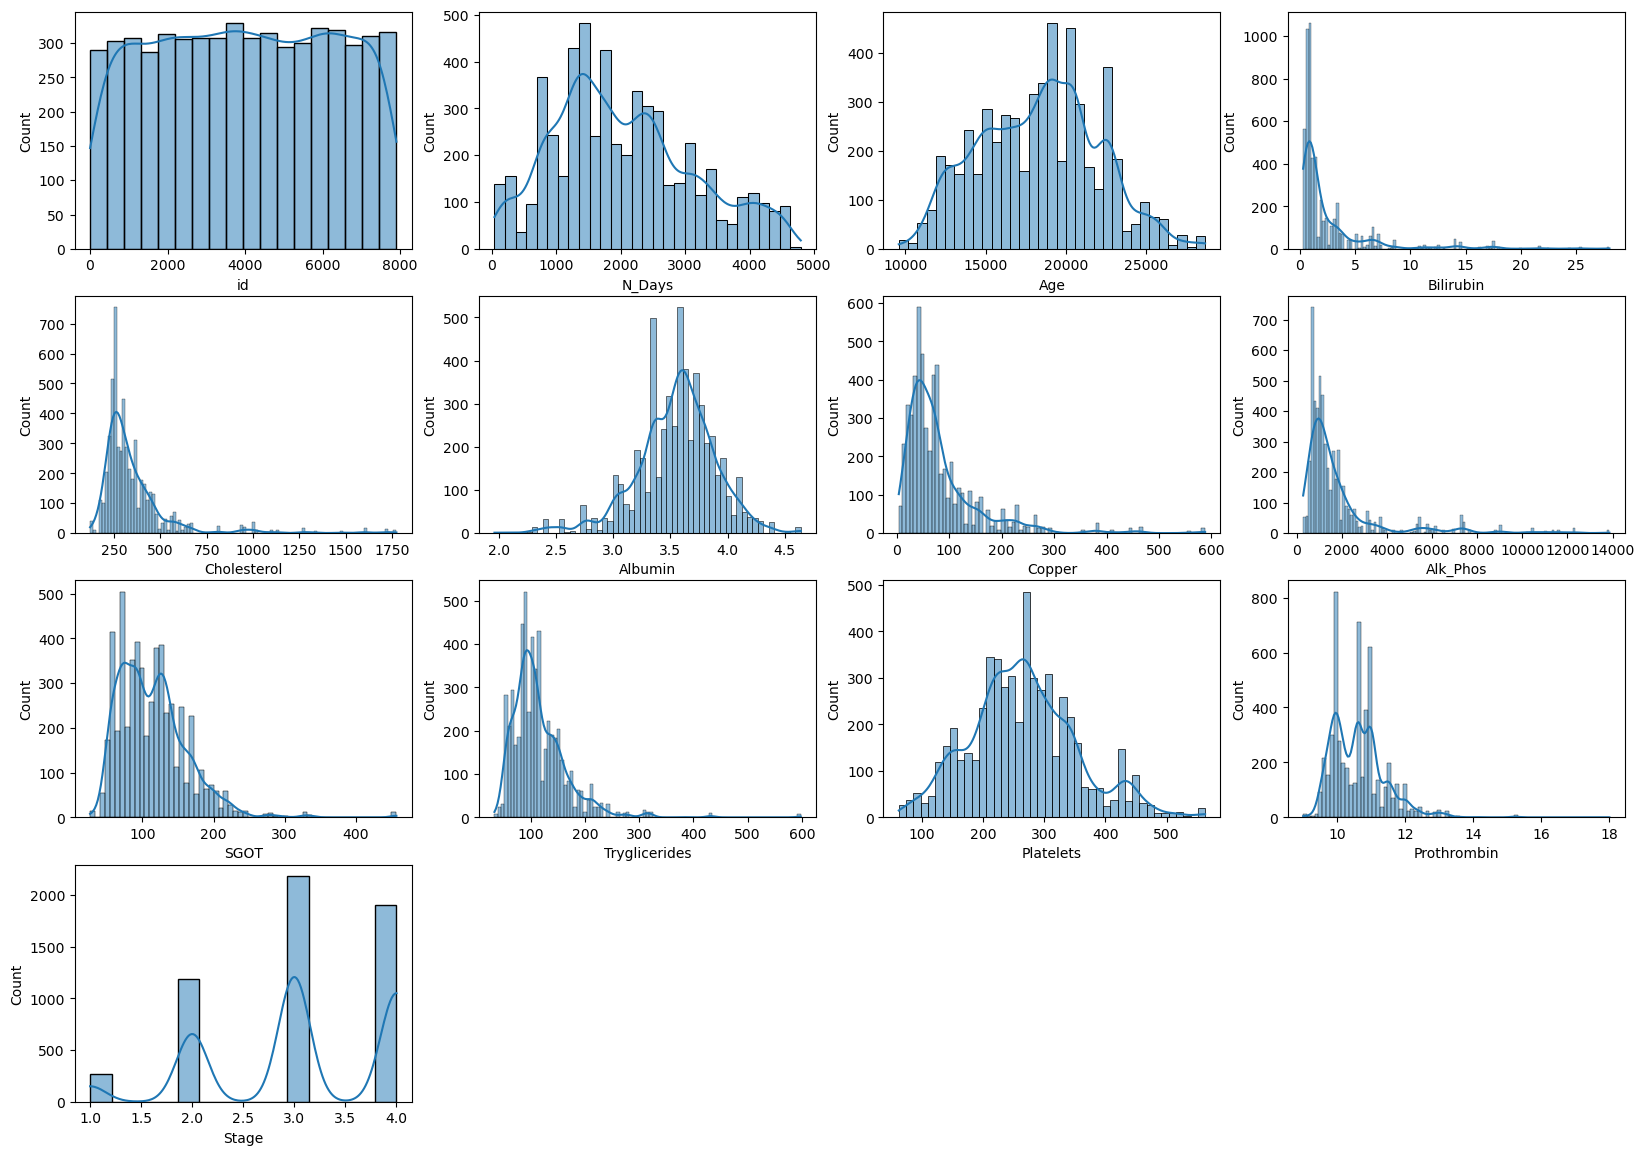

In [12]:
# plot histograms
fig = plt.figure(figsize=(20, 40))
ax = []
for i, val in enumerate(num_cols):
    ax.append(plt.subplot(11, 4, i + 1))
    ax.append(sns.histplot(train_dataset[val], kde=True))
plt.show()
fig.tight_layout()

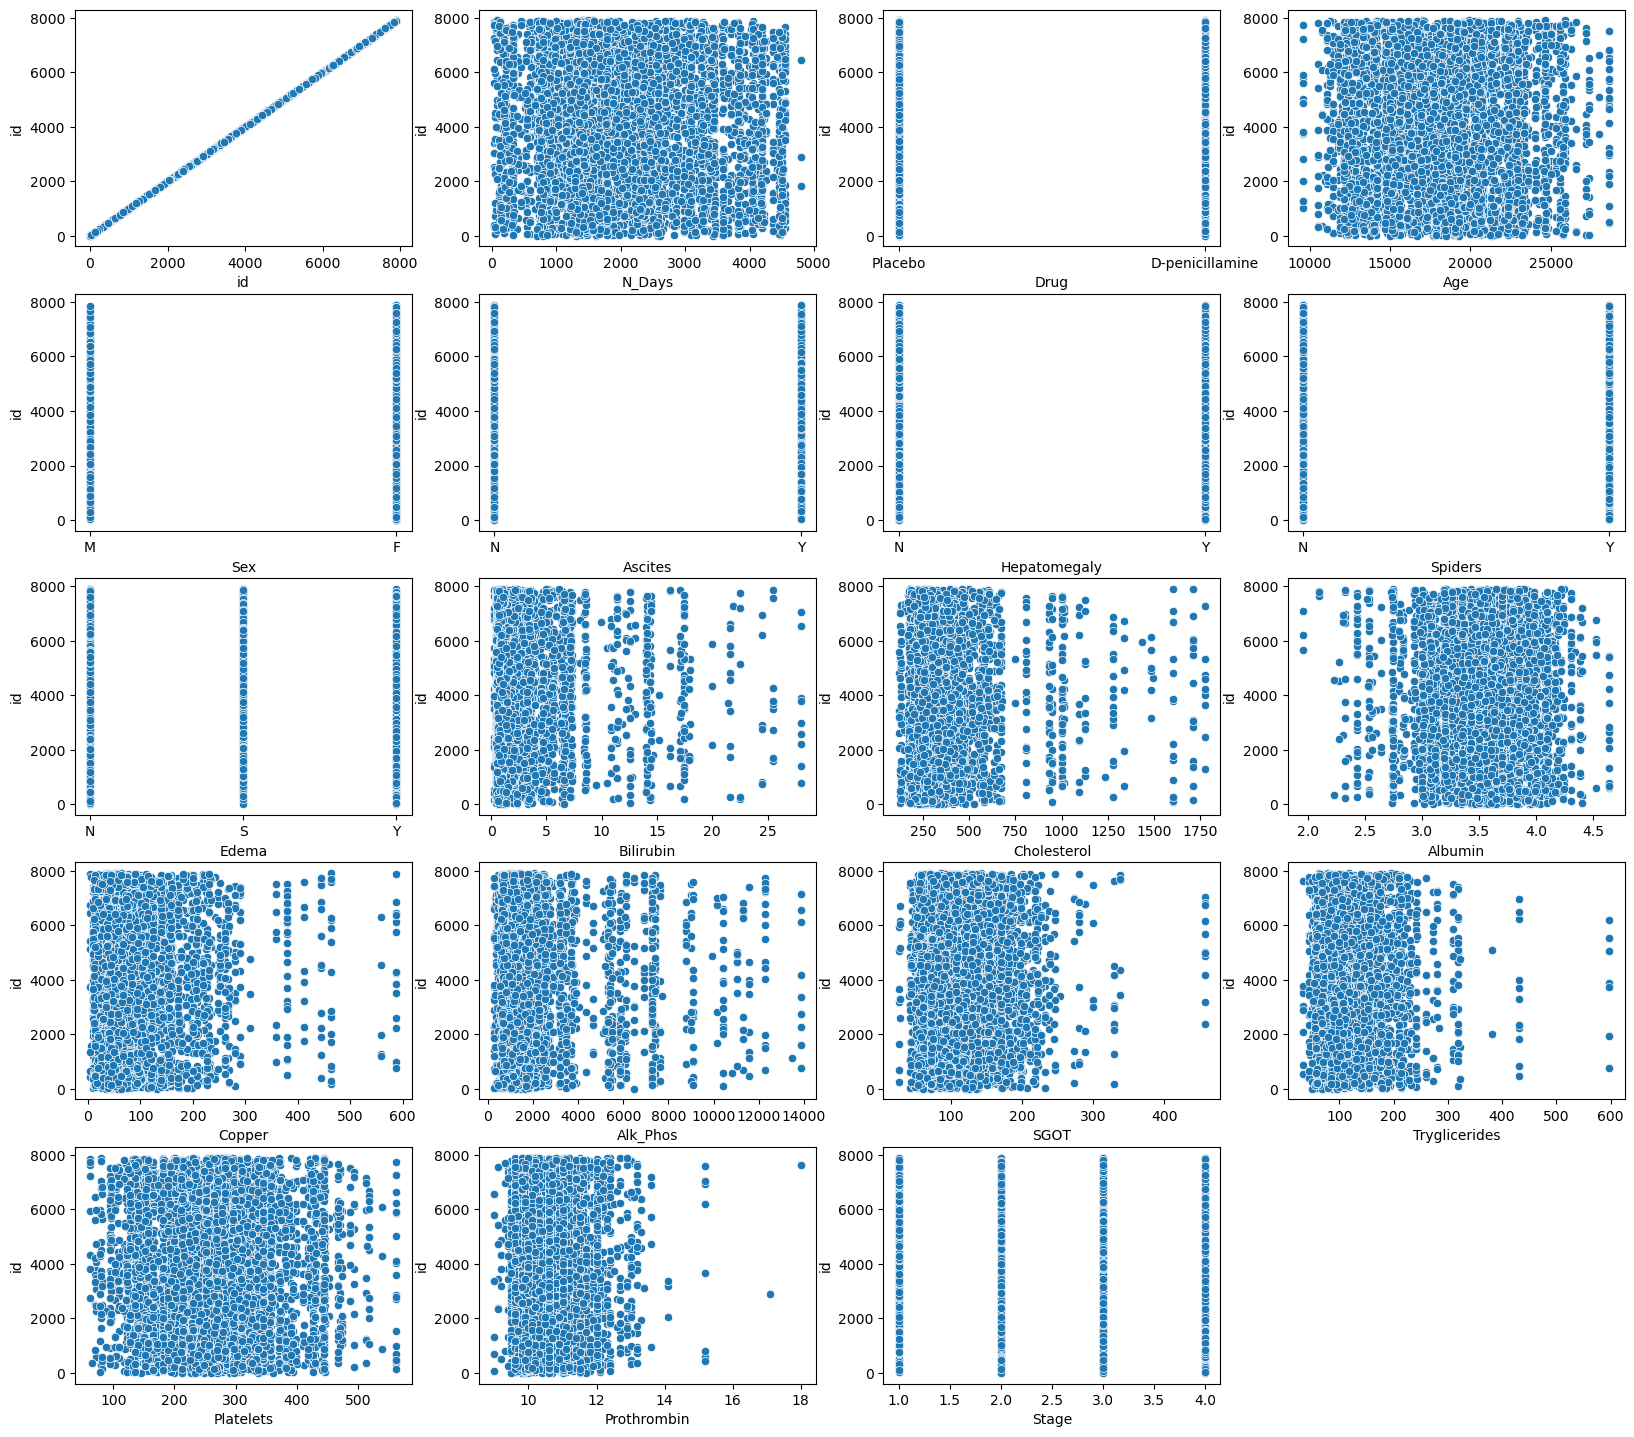

In [13]:
# plot scatterplots against id
fig = plt.figure(figsize=(20, 40))
ax = []
for i, val in enumerate(train_dataset):
    ax.append(fig.add_subplot(11, 4, i+1))
    ax.append(sns.scatterplot(x = val, y = 'id', data=train_dataset))
plt.show()
fig.tight_layout()

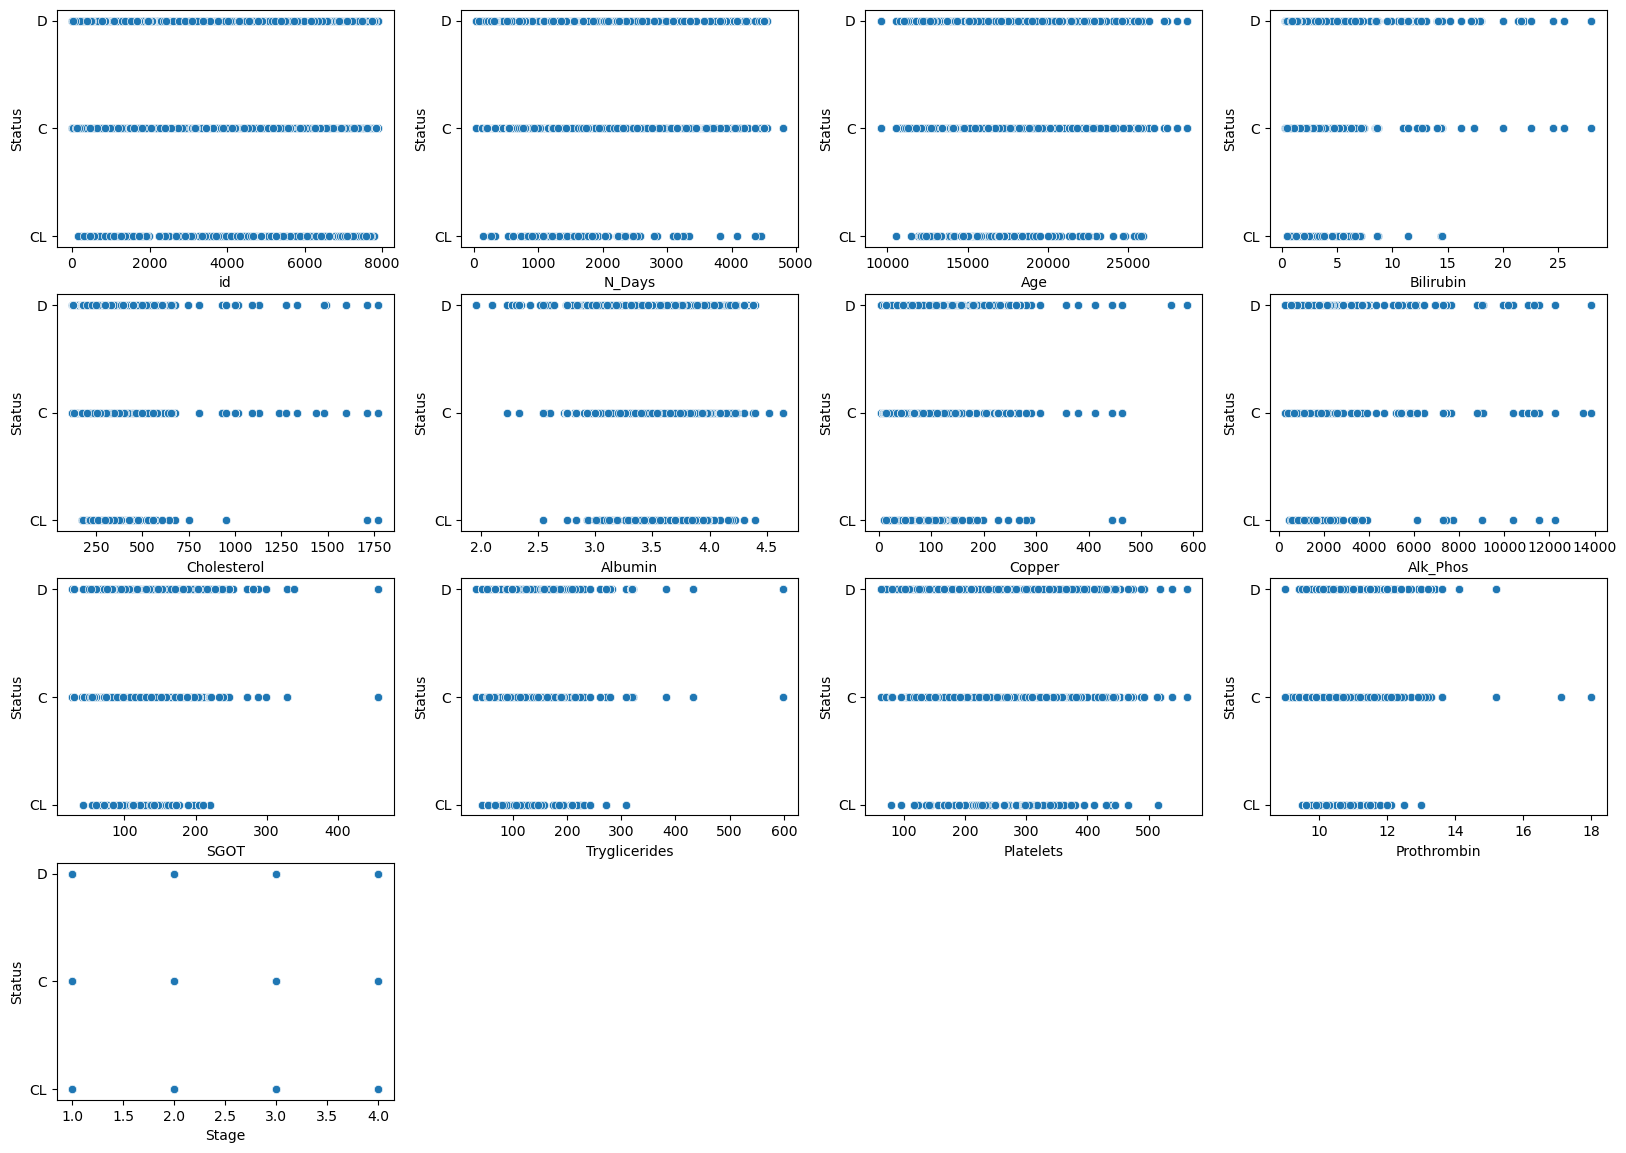

In [14]:
# visualize scatterplots agains target
train_labels_df = train_labels.to_frame(name='Status')
fig = plt.figure(figsize=(20, 40))
ax = []
for i, val in enumerate(num_cols):
    ax.append(fig.add_subplot(11, 4, i + 1))
    ax.append(sns.scatterplot(x=val, y='Status', data=pd.concat([num_data_df, train_labels_df])))
plt.show()
fig.tight_layout()

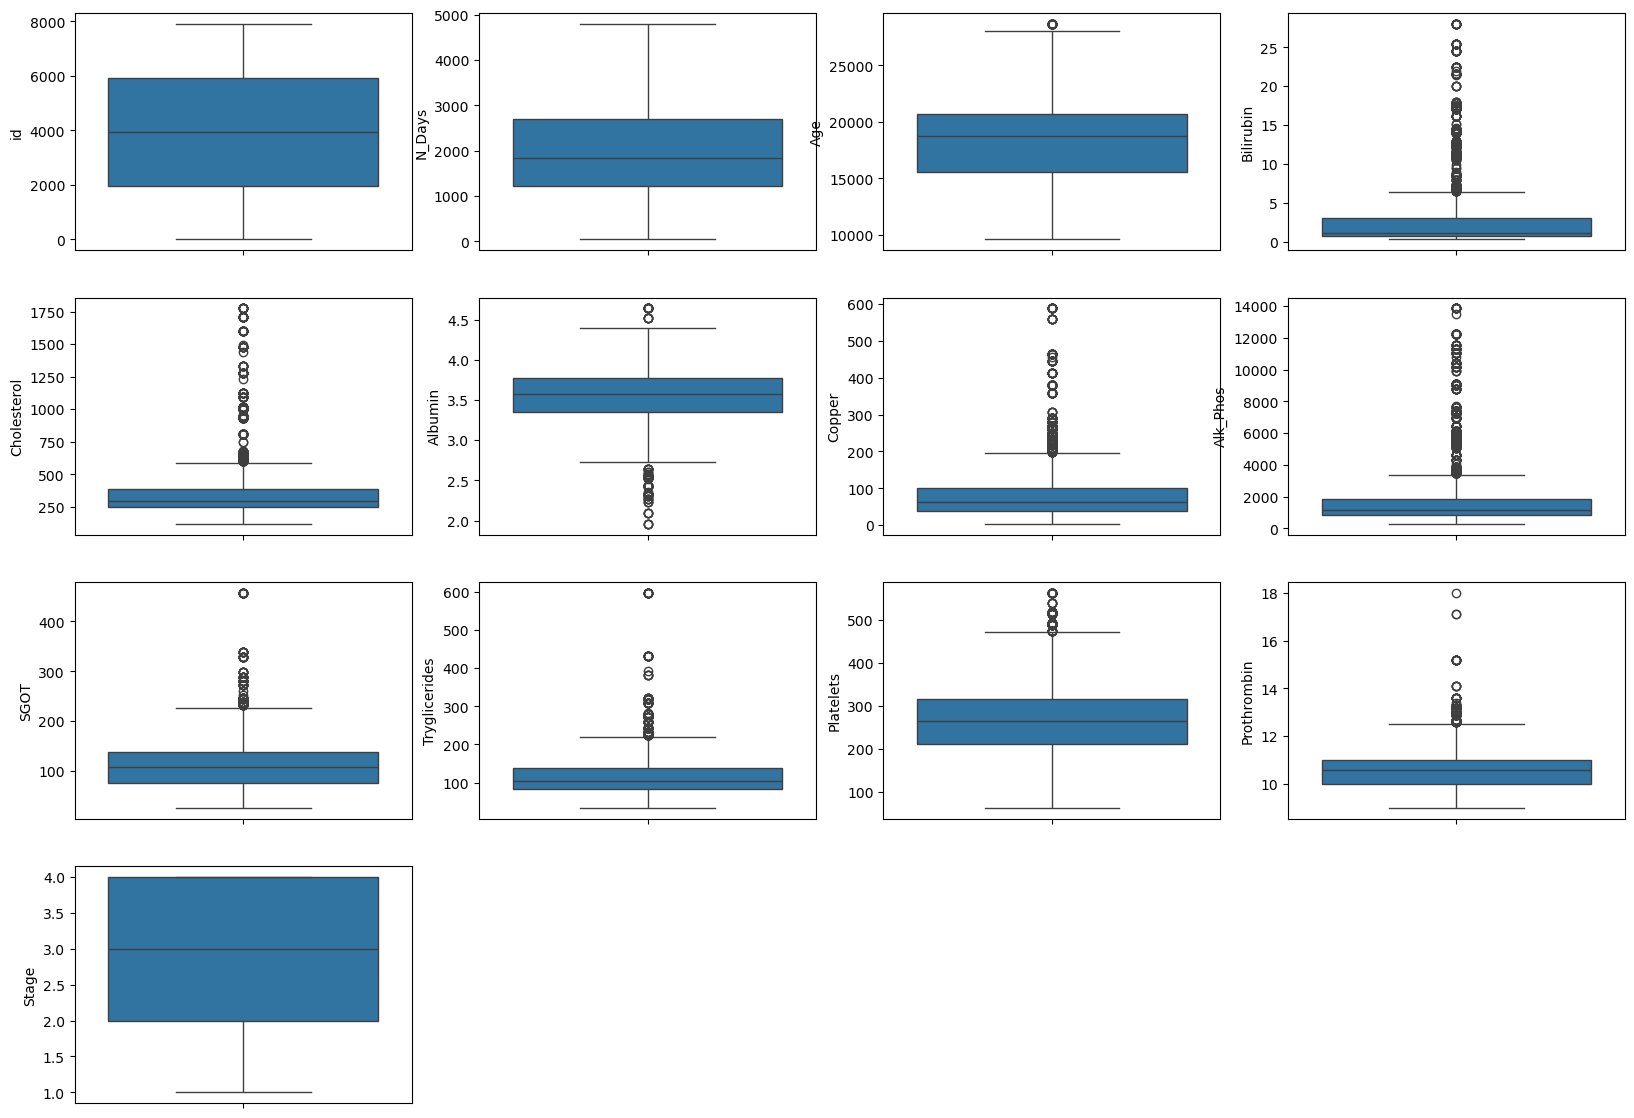

In [15]:
# visualize boxplots
fig = plt.figure(figsize=(20, 40))
ax = []
for i, val in enumerate(num_cols):
    ax.append(fig.add_subplot(11, 4, i+1))
    ax.append(sns.boxplot(y=val, data=train_data[num_cols]))
plt.show()
fig.tight_layout()

<Axes: >

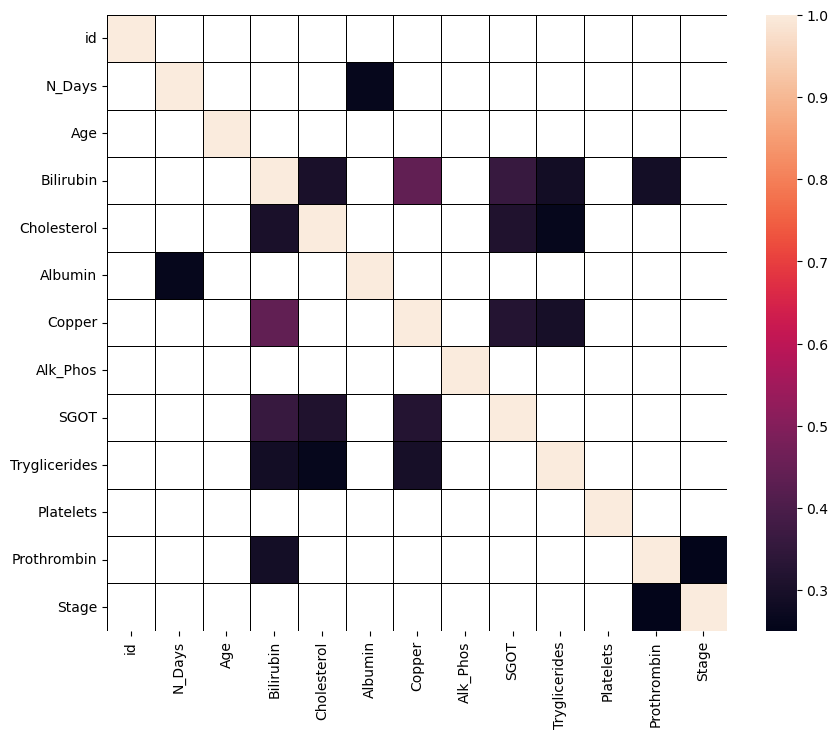

In [16]:
# Multicollinearity 
threshold = 0.25
plt.figure(figsize=(10,8))
correlation = train_dataset[num_cols].corr()
sns.heatmap(correlation, mask = correlation < threshold,linecolor='black',linewidth=.5)

## Preprocessing

#### Feature Engineering

##### Removing Features

In [17]:
# Removing Id but keeping a copy for submission
test_ids = test_data['id']

# remove from train_dataset
train_dataset = train_dataset.drop(columns='id')
val_dataset = val_dataset.drop(columns='id')
test_data = test_data.drop(columns='id')

##### Changing age values from days to years

In [18]:
train_dataset['Age'] = train_dataset['Age'] / 365
train_dataset['Age']

3755    50.279452
4010    64.232877
2656    70.884932
4320    56.347945
1611    51.956164
          ...    
5226    46.186301
5390    46.821918
860     45.802740
7603    48.394521
7270    44.600000
Name: Age, Length: 5533, dtype: float64

##### changing values that has Y/N to 1/0

In [19]:
# Train dataset
train_dataset['Spiders'] = train_dataset['Spiders'].map({'Y': 1, 'N': 0})
train_dataset['Ascites'] = train_dataset['Ascites'].map({'Y': 1, 'N':0 })
train_dataset['Hepatomegaly'] = train_dataset['Hepatomegaly'].map({'Y': 1, 'N': 0})

# validation dataset
val_dataset['Spiders'] = val_dataset['Spiders'].map({'Y': 1, 'N': 0})
val_dataset['Ascites'] = val_dataset['Ascites'].map({'Y': 1, 'N':0 })
val_dataset['Hepatomegaly'] = val_dataset['Hepatomegaly'].map({'Y': 1, 'N': 0})

# test dataset
test_data['Spiders'] = test_data['Spiders'].map({'Y': 1, 'N': 0})
test_data['Ascites'] = test_data['Ascites'].map({'Y': 1, 'N':0 })
test_data['Hepatomegaly'] = test_data['Hepatomegaly'].map({'Y': 1, 'N': 0})

print('values changed from N/Y to 1/0')

train_dataset

values changed from N/Y to 1/0


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
3755,3839,Placebo,50.279452,M,0,0,0,N,1.2,346.0,3.48,67.0,2184.0,128.65,100.0,269.0,9.9,3.0
4010,3445,Placebo,64.232877,F,0,1,1,N,0.6,286.0,3.94,96.0,856.0,71.30,90.0,410.0,11.5,4.0
2656,1447,Placebo,70.884932,F,1,1,0,N,1.4,151.0,3.40,50.0,559.0,73.53,49.0,234.0,13.0,4.0
4320,71,Placebo,56.347945,F,1,1,1,N,3.4,260.0,3.01,77.0,728.0,137.95,68.0,190.0,12.0,4.0
1611,1827,Placebo,51.956164,M,1,1,1,N,1.0,360.0,3.99,380.0,967.0,89.90,154.0,278.0,10.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,515,Placebo,46.186301,F,0,0,0,N,3.3,331.0,3.46,227.0,5300.0,52.70,99.0,190.0,10.4,3.0
5390,694,D-penicillamine,46.821918,F,0,1,1,N,0.9,300.0,3.18,231.0,1790.0,130.20,99.0,319.0,10.1,4.0
860,769,Placebo,45.802740,F,0,1,0,N,0.8,273.0,3.65,48.0,794.0,52.70,214.0,269.0,10.6,4.0
7603,2527,D-penicillamine,48.394521,F,0,0,0,N,1.1,256.0,3.54,42.0,1132.0,74.40,94.0,192.0,10.5,4.0


#### Categorical Encoding

In [20]:
# we'll use one hot encoding for simplicity
encoder = OneHotEncoder(handle_unknown='ignore')

# get categorical columns
cat_cols = [cname for cname in train_dataset.columns if 
           train_dataset[cname].dtype == "object"]

print(cat_cols)

# fit the encoder in the train it data and use it in other datasets
train_data_encoded = encoder.fit_transform(train_dataset[cat_cols])
val_data_encoded = encoder.transform(val_dataset[cat_cols])
test_data_encoded = encoder.transform(test_data[cat_cols])

# convert to pandas dataframes
train_data_encoded_df = pd.DataFrame(train_data_encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols))
val_data_encoded_df = pd.DataFrame(val_data_encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols))
test_data_encoded_df = pd.DataFrame(test_data_encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols))

# drop original cat_cols
train_dataset = train_dataset.drop(columns=cat_cols, axis=1)
val_dataset = val_dataset.drop(columns=cat_cols, axis=1)
test_data = test_data.drop(columns=cat_cols, axis=1)

# # concat encoded datasets values with original datasets
train_dataset_encoded = pd.concat([train_dataset.reset_index(drop=True), train_data_encoded_df], axis=1)
val_dataset_encoded = pd.concat([val_dataset.reset_index(drop=True), val_data_encoded_df], axis=1)
test_dataset_encoded = pd.concat([test_data.reset_index(drop=True), test_data_encoded_df], axis=1)
val_dataset_encoded
        

['Drug', 'Sex', 'Edema']


,N_Days,Age,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,...,Platelets,Prothrombin,Stage,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Edema_N,Edema_S,Edema_Y
0,971,20555,0,0,0,0.8,328.0,3.50,65.0,688.0,...,265.0,9.8,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1810,20555,0,1,1,3.3,361.0,3.57,34.0,12258.8,...,341.0,10.6,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2176,17263,0,0,0,1.2,232.0,3.98,11.0,1074.0,...,223.0,9.9,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1462,23331,0,0,0,0.4,258.0,3.74,49.0,559.0,...,284.0,10.5,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,1216,19994,0,1,0,0.7,336.0,3.36,44.0,1826.0,...,256.0,9.5,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2367,3707,24681,0,1,0,2.1,562.0,3.83,102.0,975.0,...,151.0,10.2,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2368,1412,15116,0,0,0,3.6,271.0,2.77,208.0,3472.0,...,151.0,10.3,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2369,2157,22156,0,0,1,1.2,274.0,3.50,159.0,1868.0,...,514.0,10.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2370,2835,20354,0,1,1,5.1,353.0,2.94,121.0,721.0,...,144.0,11.1,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


#### Normalization

In [21]:
# difference against other attempts we are going to use another type of scaler, StandardScaler
scaler = StandardScaler()

train_dataset_scaled = scaler.fit_transform(train_dataset_encoded)
val_dataset_scaled = scaler.fit_transform(val_dataset_encoded)
test_dataset_scaled = scaler.transform(test_dataset_encoded)

print(np.max(train_dataset_scaled))
print(np.min(train_dataset_scaled))

9.445460584123104
-4.5994889245235715


## Build The Models

##### Encoding the Target

In [22]:
# because we have categorical data in our labels, we'll encode them
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.fit_transform(val_labels)

print('values encoded', f'{train_labels_encoded}, {val_labels_encoded}')

values encoded [2 0 2 ... 0 0 0], [0 0 0 ... 0 2 0]


#### Models Implementation

Here we are going to use ensemble models, for each we are going to create a function that determines the right parameters to pass into the ensemble, this with the help of the optuna library

##### Light Gradient Boosting Machine

In [23]:

# LightGBM classifier
def LGBM_objective(trial):
    params = {
        'objective': 'multiclass',
        'metric': 'softmax',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1) 
    }

    model = LGBMClassifier(**params)

    # train the model
    model.fit(train_dataset_scaled, train_labels)

    # make predictions
    val_pred_proba = model.predict_proba(val_dataset_scaled)

    # calculate the log loss
    loss = log_loss(val_labels, val_pred_proba)
    return loss

In [24]:
# Perform hyperparameter optimization
# lgbm_study = optuna.create_study(direction='minimize')
# lgbm_study.optimize(LGBM_objective, n_trials=1500)

In [25]:
# Print the best hyperparameters and corresponding accuracy
# lgbm_best_trial = lgbm_study.lgbm_best_trial
# print(f"Best Trial - Hyperparameters: {lgbm_best_trial.params}")
# print(f"Best Trial - Accuracy: {lgbm_best_trial.value}")

In [26]:
# based on the outputs from the previous cell and the optuna helper, we set the suggested values
lgbm_model = LGBMClassifier(**{'objective': 'multiclass',
                               'metric': 'softmax',
                               'boosting_type': 'gbdt', 'num_leaves': 13,
                               'learning_rate': 0.040717487378551125,
                               'n_estimators': 340,
                               'subsample': 0.7621117946415148,
                               'colsample_bytree': 0.5254951985706161,
                               'reg_alpha': 0.9395639914591739,
                               'reg_lambda': 0.12423847695048462
                               })

##### XGBoost - Extreme Gradient Boosting

In [27]:
def XGBoost_objective(trial):
    params = {
        'objective':'multi:softprob',
        'max_depth': trial.suggest_int('max_depth', 3, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear','dart'])
    }

    model = XGBClassifier(**params)

    # train the model
    model.fit(train_dataset_scaled, train_labels_encoded)

    # make predictions
    val_pred_proba = model.predict_proba(val_dataset_scaled)

    # calculate the log loss
    loss = log_loss(val_labels_encoded, val_pred_proba)
    return loss

In [28]:
# Perform hyperparameter optimization
# xgb_study = optuna.create_study(direction='minimize')
# xgb_study.optimize(XGBoost_objective, n_trials=1500)

In [29]:
# Print the best hyperparameters and corresponding accuracy
# xgb_best_trial = xgb_study.xgb_best_trial
# print(f"Best Trial - Hyperparameters: {xgb_best_trial.params}")
# print(f"Best Trial - Accuracy: {xgb_best_trial.value}")

In [30]:
xgb_model = XGBClassifier(**{'objective':'multi:softprob',
                           'max_depth': 78, 
                           'learning_rate': 0.08038122449289681, 
                           'n_estimators': 250, 
                           'subsample': 0.6095349691489983, 
                           'colsample_bytree': 0.3967522739768332, 
                           'gamma': 0.9644640960422188, 
                           'booster': 'gbtree'})

##### Catboost - Categorical Boosting

In [31]:
def catBoost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'bootstrap_type': 'Bayesian',
        'verbose': False
    }

    if params['bootstrap_type'] == 'Bayesian':
        del params['subsample']
    
    model = CatBoostClassifier(**params)

    # Train the model
    model.fit(train_dataset_scaled, train_labels_encoded)

    # Make predictions
    val_pred_proba = model.predict_proba(val_dataset_scaled)

    # calculate log loss
    loss = log_loss(val_labels_encoded, val_pred_proba)
    return loss

In [32]:
# perform parameter optmiziation
# catb_study = optuna.create_study(direction='minimize')
# catb_study.optimize(catBoost_objective, n_trials=150)

In [33]:
# Print the best hyperparameters and corresponding accuracy
# catb_best_trial = catb_study.best_trial
# print(f"Best Trial - Hyperparameters: {catb_best_trial.params}")
# print(f"Best Trial - Loss: {catb_best_trial.value}")

In [34]:
catb_model = CatBoostClassifier(**{
    'iterations': 610, 
    'learning_rate': 0.11913005673684413, 
    'depth': 4, 
    'colsample_bylevel': 0.5729038417134726, 
    'bootstrap_type': 'Bayesian', 
    'verbose': False
    })

#### Final Model (Voting)

In [35]:
model = VotingClassifier(estimators=[
    ('model1', lgbm_model),
    ('model2', xgb_model), 
    ('model3', catb_model)
], voting='soft')

model.fit(train_dataset_scaled, train_labels_encoded)
print('voting finished')

### Make Predictions

In [ ]:
val_preds = model.predict_proba(val_dataset_scaled)
model_log_loss = log_loss(val_labels_encoded, val_preds)
print(model_log_loss)

## Submissions

In [ ]:
preds = model.predict_proba(test_dataset_scaled)

In [ ]:
submission = pd.DataFrame({
     "id": test_ids,
     "Status_C": preds[:, 0],
     "Status_CL": preds[:, 1],
     "Status_D": preds[:, 2]
 })

submission.head()

In [ ]:
submission.to_csv('./voting_ensembled_model_submission.csv', index=False, header=True)

position 896 on late submission with a log_loss of 0.4315 :)